In [1]:
# Imports

import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
train, test = np.load("train.npy"), np.load("test.npy")

# Multi-class Classification

## Random Forest Classifier

In [3]:
x_train, x_test, y_train, y_test = train[:, 1:], test[:, 1:], train[:, 0], test[:, 0]

In [4]:
%%time

rf_clf = RandomForestClassifier(n_estimators=200, random_state=0)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

y_pred_prob = rf_clf.predict_proba(x_test)

CPU times: user 4.1 s, sys: 84 ms, total: 4.19 s
Wall time: 4.19 s


In [5]:
auc_scores = []
cls = [1, 2, 3, 4, 5]
for i in range(len(rf_clf.classes_)):
    y_true_class_i = np.where(y_test == cls[i], 1, 0)
    y_pred_prob_class_i = y_pred_prob[:, i]
    auc_score_class_i = roc_auc_score(y_true_class_i, y_pred_prob_class_i)
    auc_scores.append(auc_score_class_i)
    print(f"Random Forest AUC Score for Class {cls[i]}: {auc_score_class_i}")
    
weighted_auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')
print(f"\n\nRandom Forest weighted AUC Score: {weighted_auc_score}")

Random Forest AUC Score for Class 1: 0.6598521096128752
Random Forest AUC Score for Class 2: 0.665670456209931
Random Forest AUC Score for Class 3: 0.5727694454312824
Random Forest AUC Score for Class 4: 0.5585147988236029
Random Forest AUC Score for Class 5: 0.6880580838249603


Random Forest weighted AUC Score: 0.591775083658257


In [6]:
columns = ["sum_steps", "minute_in_bed", "minute_asleep", "minute_awake",
                        "minute_deep", "minute_light", 
                        "minute_rem", "minute_wake"]

weights = rf_clf.feature_importances_

feat_weight_map = {}

for i, feature_name in enumerate(columns):
    feat_weight_map[feature_name] = weights[i]

feat_weight_map = dict(sorted(feat_weight_map.items(), key=lambda x: x[1], reverse=True))

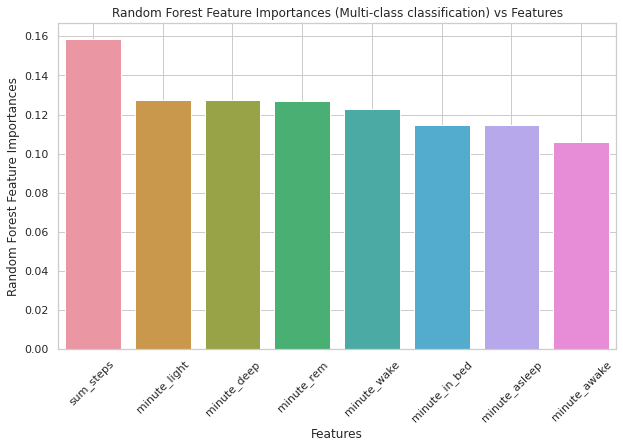

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

features = list(feat_weight_map.keys())[:]
weights = np.abs(list(feat_weight_map.values()))  # Looking at absolute values for weightage of each feature

sns.set(style="whitegrid", palette="viridis")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=weights)
plt.xlabel("Features")
plt.ylabel("Random Forest Feature Importances")
plt.title("Random Forest Feature Importances (Multi-class classification) vs Features")
plt.xticks(rotation=45)
plt.grid(True)
# Show the plot
plt.show()

## XGBoost Classifier

In [8]:
from xgboost import XGBClassifier

In [9]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train-1)
# y_pred_xgb = xgb_clf.predict(x_test)
y_pred_prob = xgb_clf.predict_proba(x_test)
cls = [1, 2, 3, 4, 5]
auc_scores = []

for i in range(len(xgb_clf.classes_)):
    y_true_class_i = np.where(y_test-1 == cls[i]-1, 1, 0)
    y_pred_prob_class_i = y_pred_prob[:, i]
    auc_score_class_i = roc_auc_score(y_true_class_i, y_pred_prob_class_i)
    auc_scores.append(auc_score_class_i)
    print(f"XGBoost AUC Score for Class {cls[i]}: {auc_score_class_i}")
    
weighted_auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')
print(f"\n\nXGBoost weighted AUC Score: {weighted_auc_score}")

XGBoost AUC Score for Class 1: 0.6966217195882268
XGBoost AUC Score for Class 2: 0.649744233997724
XGBoost AUC Score for Class 3: 0.5706050519248493
XGBoost AUC Score for Class 4: 0.5415577633054637
XGBoost AUC Score for Class 5: 0.666319756629266


XGBoost weighted AUC Score: 0.5806519657746796


## Decision Tree Classifier

In [10]:
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz

In [11]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)

y_pred_prob = dt_model.predict_proba(x_test)

In [12]:
auc_scores = []
cls = [1, 2, 3, 4, 5]
for i in range(len(dt_model.classes_)):
    y_true_class_i = np.where(y_test == cls[i], 1, 0)
    y_pred_prob_class_i = y_pred_prob[:, i]
    auc_score_class_i = roc_auc_score(y_true_class_i, y_pred_prob_class_i)
    auc_scores.append(auc_score_class_i)
    print(f"Decision Tree AUC Score for Class {cls[i]}: {auc_score_class_i}")
    
weighted_auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')
print(f"\n\nDecision Tree weighted AUC Score: {weighted_auc_score}")

Decision Tree AUC Score for Class 1: 0.4928374655647383
Decision Tree AUC Score for Class 2: 0.5193077980462633
Decision Tree AUC Score for Class 3: 0.5057202288091525
Decision Tree AUC Score for Class 4: 0.5063946128335091
Decision Tree AUC Score for Class 5: 0.5402913428497531


Decision Tree weighted AUC Score: 0.510980942309238


In [13]:
# The below code is used to get visualizations of the Decision Tree

# columns = ["sum_steps", "minute_in_bed", "minute_asleep", "minute_awake",
#                         "minute_deep", "minute_light", 
#                         "minute_rem", "minute_wake"]

# export_graphviz(dt_model, out_file='tree.dot', feature_names=columns, class_names=["0", "1", "2", "3", "4", "5"], filled=True)

In [14]:
# with open("tree.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

## Logistic Regression Classifier

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)

y_pred_prob = dt_model.predict_proba(x_test)
cls = [1, 2, 3, 4, 5]
auc_scores = []

for i in range(len(lr.classes_)):
    y_true_class_i = np.where(y_test == cls[i], 1, 0)
    y_pred_prob_class_i = y_pred_prob[:, i]
    auc_score_class_i = roc_auc_score(y_true_class_i, y_pred_prob_class_i)
    auc_scores.append(auc_score_class_i)
    print(f"Logistic Regression AUC Score for Class {cls[i]}: {auc_score_class_i}")
    
weighted_auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')
print(f"\n\nLogistic Regression weighted AUC Score: {weighted_auc_score}")

Logistic Regression AUC Score for Class 1: 0.4928374655647383
Logistic Regression AUC Score for Class 2: 0.5193077980462633
Logistic Regression AUC Score for Class 3: 0.5057202288091525
Logistic Regression AUC Score for Class 4: 0.5063946128335091
Logistic Regression AUC Score for Class 5: 0.5402913428497531


Logistic Regression weighted AUC Score: 0.510980942309238


In [17]:
columns = ["sum_steps", "minute_in_bed", "minute_asleep", "minute_awake",
                        "minute_deep", "minute_light", 
                        "minute_rem", "minute_wake"]

weights = lr.coef_

feat_weight_map = {}

for i, feature_name in enumerate(columns):
    feat_weight_map[feature_name] = weights[0][i]

feat_weight_map = dict(sorted(feat_weight_map.items(), key=lambda x: abs(x[1]), reverse=True))

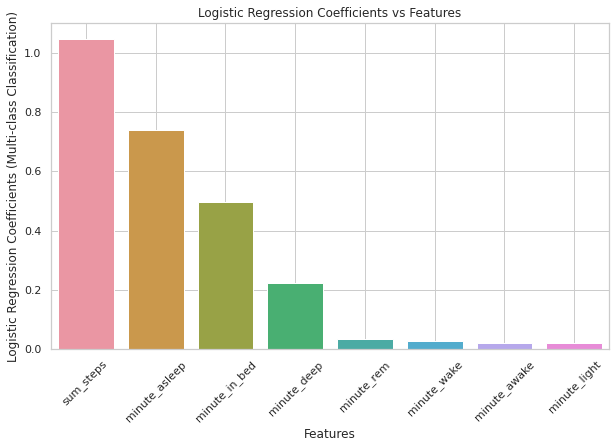

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

features = list(feat_weight_map.keys())[:]
weights = np.abs(list(feat_weight_map.values()))  # Looking at absolute values for weightage of each feature

sns.set(style="whitegrid", palette="viridis")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=weights)
plt.xlabel("Features")
plt.ylabel("Logistic Regression Coefficients (Multi-class Classification)")
plt.title("Logistic Regression Coefficients vs Features")
plt.xticks(rotation=45)
plt.grid(True)
# Show the plot
plt.show()

# Converting the multi-class classification task to binary class classification task

In [19]:
x_train, x_test, y_train, y_test = train[:, 1:], test[:, 1:], train[:, 0], test[:, 0]

y_train_binary = np.where((y_train == 4) | (y_train == 5), 1, 0)
y_test_binary = np.where((y_test == 4) | (y_test == 5), 1, 0)

In [20]:
np.unique(y_train, return_counts=True)  # Checking to see if the values of the positive class match

(array([1., 2., 3., 4., 5.]), array([ 115,  836, 2434, 2973, 1050]))

In [21]:
y_train_binary.sum()

4023

## Random Forest Classifier

In [22]:
%%time

rf_clf = RandomForestClassifier(n_estimators=200, random_state=0)
rf_clf.fit(x_train, y_train_binary)
y_pred = rf_clf.predict(x_test)

y_pred_prob = rf_clf.predict_proba(x_test)

CPU times: user 3.8 s, sys: 13 ms, total: 3.82 s
Wall time: 3.82 s


In [23]:
y_pred_prob = rf_clf.predict_proba(x_test)[:, 1]
    
auc_score = roc_auc_score(y_test_binary, y_pred_prob)
print(f"\n\nRandom Forest AUC Score: {auc_score}")



Random Forest AUC Score: 0.6674795211971936


In [24]:
columns = ["sum_steps", "minute_in_bed", "minute_asleep", "minute_awake",
                        "minute_deep", "minute_light", 
                        "minute_rem", "minute_wake"]

weights = rf_clf.feature_importances_

feat_weight_map = {}

for i, feature_name in enumerate(columns):
    feat_weight_map[feature_name] = weights[i]

feat_weight_map = dict(sorted(feat_weight_map.items(), key=lambda x: x[1], reverse=True))

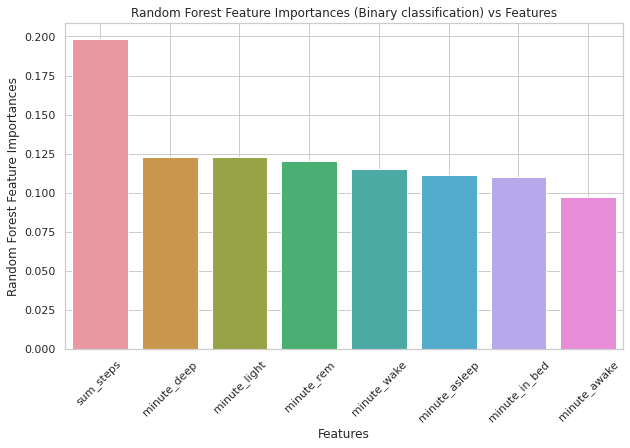

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

features = list(feat_weight_map.keys())[:]
weights = np.abs(list(feat_weight_map.values()))  # Looking at absolute values for weightage of each feature

sns.set(style="whitegrid", palette="viridis")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=weights)
plt.xlabel("Features")
plt.ylabel("Random Forest Feature Importances")
plt.title("Random Forest Feature Importances (Binary classification) vs Features")
plt.xticks(rotation=45)
plt.grid(True)
# Show the plot
plt.show()

## XGBoost Classification

In [26]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train_binary)
y_pred_prob = xgb_clf.predict_proba(x_test)

y_pred_prob = xgb_clf.predict_proba(x_test)[:, 1]
    
auc_score = roc_auc_score(y_test_binary, y_pred_prob)
print(f"\n\nXGBoost AUC Score: {auc_score}")



XGBoost AUC Score: 0.6498083902448126


## Decision Tree Classification

In [27]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train_binary)
y_pred_prob = dt_clf.predict_proba(x_test)[:, 1]
    
auc_score = roc_auc_score(y_test_binary, y_pred_prob)
print(f"\n\nDecision Tree AUC Score: {auc_score}")



Decision Tree AUC Score: 0.5407045361247947


## Logistic Regression

In [28]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train_binary)
y_pred_prob = lr.predict_proba(x_test)[:, 1]

    
auc_score = roc_auc_score(y_test_binary, y_pred_prob)
print(f"\n\nLogistic Regression AUC Score: {auc_score}")



Logistic Regression AUC Score: 0.6899070756829377


In [29]:
columns = ["sum_steps", "minute_in_bed", "minute_asleep", "minute_awake",
                        "minute_deep", "minute_light", 
                        "minute_rem", "minute_wake"]

weights = lr.coef_

feat_weight_map = {}

for i, feature_name in enumerate(columns):
    feat_weight_map[feature_name] = weights[0][i]

feat_weight_map = dict(sorted(feat_weight_map.items(), key=lambda x: abs(x[1]), reverse=True))

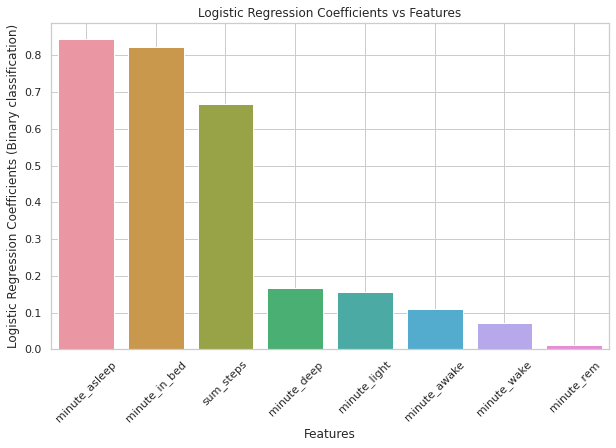

In [30]:
import seaborn as sns

features = list(feat_weight_map.keys())[:]
weights = np.abs(list(feat_weight_map.values()))  # Looking at absolute values for weightage of each feature

sns.set(style="whitegrid", palette="viridis")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=weights)
plt.xlabel("Features")
plt.ylabel("Logistic Regression Coefficients (Binary classification)")
plt.title("Logistic Regression Coefficients vs Features")
plt.xticks(rotation=45)
plt.grid(True)
# Show the plot
plt.show()